In [65]:
from google.cloud import storage
from io import StringIO
import numpy as np
import altair as alt
import pandas as pd
from tqdm import tqdm
from math import sin, cos, sqrt, atan2, radians

In [66]:
client = storage.Client()

In [67]:
bucket = client.get_bucket('locate-a-locum-m2-analytics')

In [68]:
def convert_csv_to_output(filename):
    
    blob = bucket.get_blob(filename)
    bt = blob.download_as_string()
    s = str(bt,'utf-8')
    s = StringIO(s)
    
    return s

In [69]:
shifts_df = pd.read_csv(convert_csv_to_output('sample-data-shifts.csv'),parse_dates=['Posted Date','Start Time','End Time'])
users_df = pd.read_csv(convert_csv_to_output('sample-data-users.csv'),parse_dates=['Created Date'])
applications_df = pd.read_csv(convert_csv_to_output('sample-data-applications.csv'))

In [70]:
shifts_df['Latitude'] = shifts_df['Latitude'].apply(lambda x: float(x))

In [71]:
def calculate_shift_distance_to_user(user_latitude, user_longitude, shift_latitude, shift_longitude):
    '''Calculates shift distance to user'''
    # Calculate difference between user latitude and shift latitude
    latitude_difference = user_latitude - shift_latitude
    
    # Calculate difference between user longitude and shift longitude
    longitude_difference = user_longitude - shift_longitude
    
    # Apply haversine formula to calculat distance
    R = radius_of_the_earth = 6373.0
    
    a = sin(latitude_difference / 2)**2 + cos(user_latitude) * cos(shift_latitude) * sin(longitude_difference / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    shift_distance_to_user = R * c
    
    return shift_distance_to_user



def is_user_eligible_for_shift(user_create_date, shift_post_date):
    '''Determines if a user is eligible for a shift'''
    # Compare user create date to shift post date
    eligibility_ind = False
    
    if user_create_date <= shift_post_date:
        eligibility_ind = True
    
    return eligibility_ind



def count_eligible_shifts(user_create_date):
    '''Counts shifts that a user is eligible for'''
    # Create list of shift dates
    shift_dates = shifts_df['Posted Date'].tolist()
    
    # Sum the user eligible shifts by feeding the shift dates and user create dates into the eligibility function
    shifts_eligible_cnt = sum([is_user_eligible_for_shift(user_create_date, date) for date in shift_dates])

    return shifts_eligible_cnt



def count_shifts_in_radius(user_create_date, user_latitude, user_longitude, travel_radius):
    '''Counts shifts in a user's work radius'''
    # Determine whether a shift is eligible for counting
    shift_dates = shifts_df['Posted Date'].tolist()
    
    eligbile_shifts = [is_user_eligible_for_shift(user_create_date, date) for date in shift_dates]
    
    shift_coordinates = list(shifts_df[['Latitude','Longitude']][eligbile_shifts].to_records(index=False))
    
    # Sum the user eligible shifts that are less than or equal to the user travel radius by feeding the user lat/long and shift lat/long into the calculate shift distance to user function
    in_radius_cnt = sum([calculate_shift_distance_to_user(user_latitude, user_longitude, shift_latitude, shift_longitude) <= travel_radius for shift_latitude, shift_longitude in shift_coordinates])
 
    return in_radius_cnt

In [72]:
users_test_df = users_df.iloc[:5000]

In [73]:
# np.vectorize(count_shifts_in_radius)(list(users_test_df[['Created Date','Latitude','Longitude','Travel Radius']].to_records(index=False)))
users_test_df['shifts_in_radius'] = np.vectorize(count_shifts_in_radius)(users_test_df['Created Date'], users_test_df['Latitude'], users_test_df['Longitude'], users_test_df['Travel Radius'])
users_test_df['shifts_eligible'] = users_test_df['Created Date'].apply(count_eligible_shifts)

<ipython-input-73-0014165f0f78>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_test_df['shifts_in_radius'] = np.vectorize(count_shifts_in_radius)(users_test_df['Created Date'], users_test_df['Latitude'], users_test_df['Longitude'], users_test_df['Travel Radius'])
<ipython-input-73-0014165f0f78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_test_df['shifts_eligible'] = users_test_df['Created Date'].apply(count_eligible_shifts)


In [76]:
users_test_df.to_feather('users_0_5000.feather')

In [75]:
!pip install pyarrow

     |████████████████████████████████| 21.9 MB 5.0 MB/s eta 0:00:01


In [83]:
df = pd.read_feather('users_0_5000.feather')
df2 = pd.read_feather('users_10000_15000.feather')
df1 = pd.read_feather('users_5000_10000.feather')
df3 = pd.read_feather('users_15000_end.feather')

In [85]:
concat_df = pd.concat([df,df1,df2,df3])

In [86]:
concat_df.head()

,User ID,Latitude,Longitude,Created Date,Travel Radius,shifts_in_radius,shifts_eligible
0,32763,51.507351,-0.127758,2021-05-04 09:47:00,60,0,0
1,32761,51.507351,-0.127758,2021-05-04 09:09:12,60,0,0
2,32756,56.500282,-3.011852,2021-05-04 07:45:04,60,0,0
3,32752,53.777535,-2.701210,2021-05-04 03:08:49,60,0,0
4,32751,53.509730,-2.418393,2021-05-03 23:18:13,30,0,0


<AxesSubplot:>

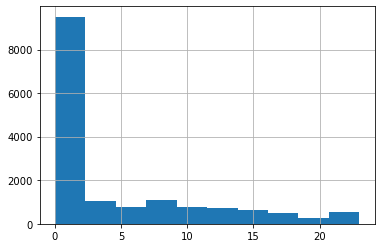

In [90]:
concat_df[concat_df['shifts_in_radius'] < 24]['shifts_in_radius'].hist()

In [92]:
concat_df.to_csv('shifts_in_radius.csv',index=False)

In [97]:
concat_df.to_gbq('locate-a-locem.shifts_in_radius','m2-analytics')

Forbidden: 403 GET https://bigquery.googleapis.com/bigquery/v2/projects/m2-analytics/datasets/locate-a-locem/tables/shifts_in_radius?prettyPrint=false: Request had insufficient authentication scopes.

In [93]:
blob1 = bucket.blob('shifts_in_radius.csv')

In [94]:
blob1.upload_from_filename('shifts_in_radius.csv')

Forbidden: 403 POST https://storage.googleapis.com/upload/storage/v1/b/locate-a-locum-m2-analytics/o?uploadType=multipart: {
  "error": {
    "code": 403,
    "message": "Insufficient Permission",
    "errors": [
      {
        "message": "Insufficient Permission",
        "domain": "global",
        "reason": "insufficientPermissions"
      }
    ]
  }
}
: ('Request failed with status code', 403, 'Expected one of', <HTTPStatus.OK: 200>)